In [144]:
# Check logits
import os
import matplotlib.pyplot as plt

folder_path =   '/network/scratch/s/sonia.joseph/imagenet_logits'
for entry in os.listdir(folder_path):
    file_path = os.path.join(folder_path, entry)
    if os.path.isfile(file_path):
        print(f"File: {entry}")
    elif os.path.isdir(file_path):
        print(f"Folder: {entry}")

Folder: layer8_head9
Folder: layer0_head0
Folder: unablated
Folder: layer0_head1
Folder: layer0_mlp
Folder: layer1_mlp
Folder: layer2_mlp
Folder: layer3_mlp
Folder: layer0_head2
Folder: layer4_mlp
Folder: layer0_head3
Folder: layer5_mlp
Folder: layer0_head4
Folder: layer6_mlp
Folder: layer0_head5
Folder: layer7_mlp
Folder: layer0_head6
Folder: layer8_mlp
Folder: layer0_head7
Folder: layer0_head8
Folder: layer9_mlp
Folder: layer0_head9
Folder: layer10_mlp
Folder: layer0_head10
Folder: layer11_mlp
Folder: layer0_head11
Folder: layer1_head0
Folder: layer1_head1
Folder: layer1_head2
Folder: layer1_head3
Folder: layer1_head4
Folder: layer1_head5
Folder: layer1_head6
Folder: layer1_head7
Folder: layer1_head8
Folder: layer1_head9
Folder: layer1_head10
Folder: layer1_head11
Folder: layer2_head0
Folder: layer2_head1
Folder: layer2_head2
Folder: layer2_head3
Folder: layer2_head4
Folder: layer2_head5
Folder: layer2_head6
Folder: layer2_head7
Folder: layer2_head8
Folder: layer2_head9
Folder: layer

In [39]:
import json

# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'


# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Example usage
label = 0  # Replace with your label
class_name = get_class_name(label)
print(f"Class for label {label}: {class_name}")

class_name_to_lookup = "tiger_cat"  # Replace with your class name
label_from_class_name = get_label(class_name_to_lookup)
print(f"Label for class name '{class_name_to_lookup}': {label_from_class_name}")


Class for label 0: tench
Label for class name 'tiger_cat': 282


In [40]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging

# Path to your ImageNet dataset
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Transformation for the data
data_transforms = transforms.Compose([
    # Add your transformations here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)

# Function to get subset of dataset for a specific label
def get_subset_for_label(dataset, label_idx):
    # Find the index of the label
#     label_idx = dataset.class_to_idx[label]

    # Get indices of images with the specific label
    target_indices = [i for i, (_, target) in enumerate(dataset.samples) if target == label_idx]

    # Create a subset
    return Subset(dataset, target_indices)

# Specify your label here (folder name)
num_label = 'Egyptian_cat'
specific_label = int(get_label(num_label))
print(specific_label)

# Get the subset for the specific label
specific_label_subset = get_subset_for_label(imagenet_data, specific_label)

# Create a DataLoader for the subset
data_loader = DataLoader(specific_label_subset, batch_size=60, shuffle=False)

# Logging
print(f"ImageNet subset for label '{specific_label}' loaded. Total datapoints: {len(specific_label_subset)}")


285
ImageNet subset for label '285' loaded. Total datapoints: 50


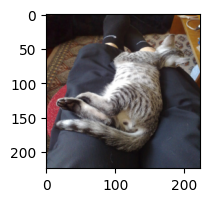

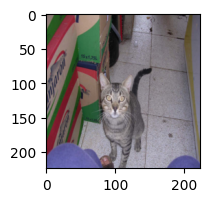

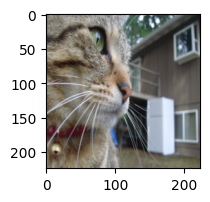

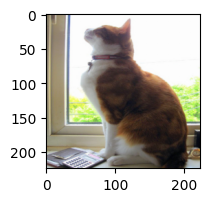

In [4]:
img, label = next(iter(data_loader))

max_count = 4
count = 0
for img, label in data_loader:
    for i in range(max_count):
        plt.figure(figsize=(2,2))
        plt.imshow(img[i].permute(1,2,0))



In [244]:
import h5py
import os
import numpy as np

# Path to your HDF5 file

def read_accuracies_from_file(file_path):
    """
    Reads a .txt file and extracts accuracy values formatted like "Accuracy for Layer 0, Head 0: 0.7198".

    :param file_path: Path to the .txt file.
    :return: A dictionary with the layer and head as keys and the accuracy as values.
    """
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if 'Accuracy for Layer' in line:
                    parts = line.strip().split(',')
                    parts = parts[-1].split(':')
                    acc = parts[-1].strip()
        return float(acc)
    except Exception as e:
        print(f"Error reading file: {e}")

def get_logits(ablation_type='layer0_head0', parent_dir = '/network/scratch/s/sonia.joseph/imagenet_logits/'):
    load_path = os.path.join(parent_dir, ablation_type)
    with h5py.File(os.path.join(load_path, 'logits_and_labels.h5'), 'r') as h5f:
        logits_dataset = h5f['logits']
        labels = h5f['labels']
        indices_of_specific_label = np.where(labels[:] == specific_label)[0]
        specific_logits = logits_dataset[indices_of_specific_label]
    accuracy = read_accuracies_from_file(os.path.join(load_path, 'accuracy.txt'))
    return specific_logits, accuracy




In [245]:
# load vanilla data
parent_dir = '/network/scratch/s/sonia.joseph/imagenet_logits/'
folder = 'unablated'
vanilla_acc = read_accuracies_from_file(os.path.join(os.path.join(parent_dir,folder), 'accuracy.txt'))
vanilla_acc

0.7229

In [256]:
data = np.zeros((24,12))
for idx, layer_idx in enumerate(range(24)):
    if idx % 2 == 0: # attn
        for head_idx in range(12):
            print("On attn layer", layer_idx//2, "Head", head_idx)
            try:
                ablation_type = f'layer{layer_idx//2}_head{head_idx}'
                _, acc = get_logits(ablation_type)
                print(acc)
                data[layer_idx, head_idx] = acc
            except Exception as e:
                data[layer_idx, head_idx] = np.nan
                print(e)
    else:
        try:
            print("On mlp layer", layer_idx//2)
            ablation_type = f'layer{layer_idx//2}_mlp'
            _, acc = get_logits(ablation_type)
            print(acc)
            data[layer_idx,:] = acc
        except Exception as e:
            data[layer_idx,:] = np.nan
            print(e)



On attn layer 0 Head 0
0.7198
On attn layer 0 Head 1
0.7227
On attn layer 0 Head 2
0.718
On attn layer 0 Head 3
0.7175
On attn layer 0 Head 4
0.7131
On attn layer 0 Head 5
0.7252
On attn layer 0 Head 6
0.7184
On attn layer 0 Head 7
0.7223
On attn layer 0 Head 8
0.721
On attn layer 0 Head 9
0.723
On attn layer 0 Head 10
0.7247
On attn layer 0 Head 11
0.7039
On mlp layer 0
0.0406
On attn layer 1 Head 0
0.7133
On attn layer 1 Head 1
0.6707
On attn layer 1 Head 2
0.7188
On attn layer 1 Head 3
0.713
On attn layer 1 Head 4
0.6874
On attn layer 1 Head 5
0.719
On attn layer 1 Head 6
0.7188
On attn layer 1 Head 7
0.7162
On attn layer 1 Head 8
0.7191
On attn layer 1 Head 9
0.7133
On attn layer 1 Head 10
0.7198
On attn layer 1 Head 11
0.719
On mlp layer 1
0.6199
On attn layer 2 Head 0
0.7156
On attn layer 2 Head 1
0.7151
On attn layer 2 Head 2
0.719
On attn layer 2 Head 3
0.7151
On attn layer 2 Head 4
0.71
On attn layer 2 Head 5
0.7137
On attn layer 2 Head 6
0.7168
On attn layer 2 Head 7
0.7156
O

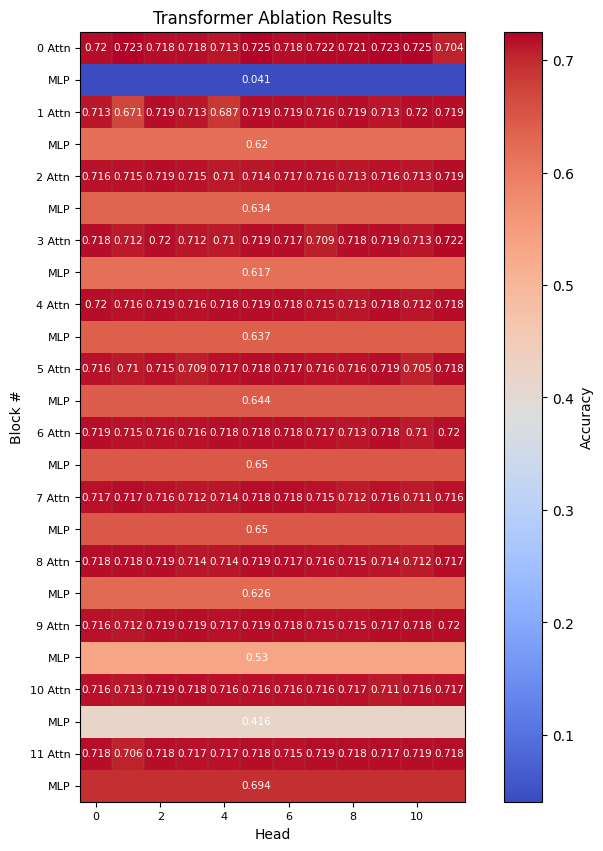

In [257]:


# Assuming 'data' is a numpy array with your results

fig, axs = plt.subplots(figsize=(10, 10))

# Setting custom y-axis labels
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
axs.set_yticks(np.arange(0, 24, 1))
axs.set_yticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)])  # Alternate labels

axs.set_ylabel('Block #') 
axs.set_xlabel('Head')
axs.set_title('Transformer Ablation Results')

axs.tick_params(axis='both', which='major', labelsize=8)

# Creating the heatmap
im = axs.imshow(data, cmap='coolwarm')  # 'viridis' is just an example colormap, you can choose another
cbar = fig.colorbar(im)
cbar.set_label("Accuracy")


# Adding text annotations
fontsize=7.5
for i in range(data.shape[0]):
    if i % 2 != 0: # if MLP layer, plot 1 value in center
        text = axs.text(5, i, round(data[i,j], 3),
                        ha="center", va="center", color="w", fontsize=fontsize)
    else:
        for j in range(data.shape[1]):
            text = axs.text(j, i, round(data[i, j], 3),
                           ha="center", va="center", color="w", fontsize=fontsize)
            
# Manually drawing grid lines only on Attn layers
for i in range(0, 24, 2):  # Loop over every other row (Attn layers)
    for j in np.arange(-0.5, 12, 1):  # Loop over vertical grid lines
        axs.vlines(j, i - 0.5, i + 0.5, colors='gray', linestyles='-', linewidth=0.2)


save_dir = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/figures/ablations'
fig_name = 'head-by-head-ablations.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')

plt.show()



In [185]:
data.mean(axis=1)

array([0.71913333, 0.0406    , 0.7107    , 0.6199    , 0.71514167,
       0.6335    , 0.715725  , 0.6166    , 0.71679167, 0.6373    ,
       0.71468333, 0.6445    , 0.71645   , 0.6503    , 0.71515833,
       0.6502    ,        nan, 0.6259    ,        nan, 0.5304    ,
              nan, 0.4155    ,        nan, 0.6942    ])

In [195]:
# Get layer-level ablations for attention, instead of head-by-head
data_layer_level = data.copy()
for idx, layer_idx in enumerate(range(24)):
#     print(f"On layer_idx {layer_idx}")
    try: 
        if idx % 2 == 0: # attn
            print("On attn layer", {idx // 2})
            ablation_type = f'layer{layer_idx//2}_headNone'
            _, acc = get_logits(ablation_type)
            print(acc)
            data_layer_level[layer_idx] = acc
        else:
            continue # keep existing mlp data
    except Exception as e:
        data_layer_level[layer_idx] = np.nan
        print(e)


On attn layer {0}
0.445
On attn layer {1}
0.4672
On attn layer {2}
0.5481
On attn layer {3}
0.6406
On attn layer {4}
0.6565
On attn layer {5}
0.6392
On attn layer {6}
0.6412
On attn layer {7}
0.6252
On attn layer {8}
0.6307
On attn layer {9}
0.6739
On attn layer {10}
0.6528
On attn layer {11}
0.5089


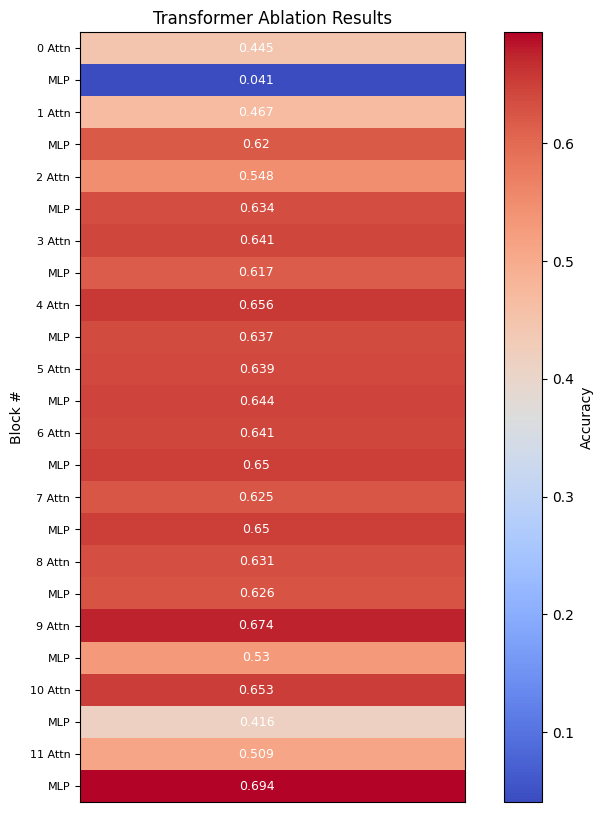

In [255]:


# Assuming 'data' is a numpy array with your results

fig, axs = plt.subplots(figsize=(10, 10))

# Setting custom y-axis labels
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
axs.set_yticks(np.arange(0, 24, 1))
axs.set_yticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)])  # Alternate labels

axs.set_ylabel('Block #') 
# axs.set_xlabel('Head')
axs.set_title('Transformer Ablation Results')
axs.set_xticks([])


axs.tick_params(axis='both', which='major', labelsize=8)


# Creating the heatmap
im = axs.imshow(data_layer_level, cmap='coolwarm')  # 'viridis' is just an example colormap, you can choose another
cbar = fig.colorbar(im)
cbar.set_label("Accuracy")

# Adding text annotations
fontsize=9
for i in range(data_layer_level.shape[0]):
    text = axs.text(5, i, round(data_layer_level[i][0], 3),
                        ha="center", va="center", color="w", fontsize=fontsize)

    
fig_name = 'layer-by-layer-ablations.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')
plt.show()


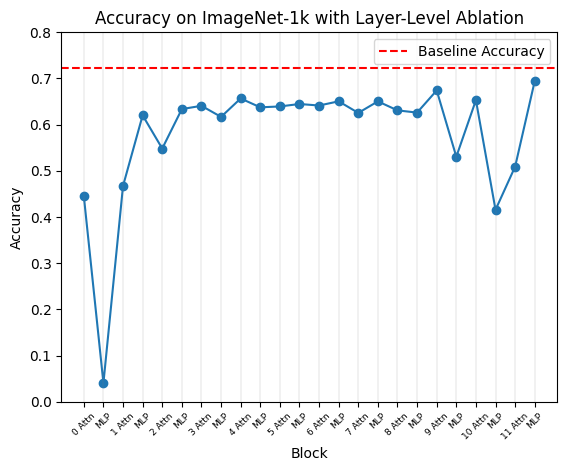

In [254]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data_layer_level' is a numpy array with your results

# Create a figure and an axes object
fig, ax = plt.subplots()

# Create a simple plot
ax.plot(range(24), data_layer_level[:,0])
ax.scatter(range(24), data_layer_level[:,0])
ax.set_title('Accuracy on ImageNet-1k with Layer-Level Ablation')
ax.set_xlabel('Block')
ax.set_ylabel('Accuracy')

# Show baseline accuracy
plt.axhline(y=vanilla_acc, color='r', linestyle='--', label='Baseline Accuracy')


# Adding custom tick marks for alternating Attn and MLP layers
layer_labels = ['Attn' if i % 2 == 0 else 'MLP' for i in range(24)]
ax.set_xticks(range(24))
ax.set_xticklabels([f'{i // 2} {layer_labels[i]}' if i % 2 == 0 else f'{layer_labels[i]}' for i in range(24)], rotation=45)  # Rotate for better readability
ax.tick_params(axis='x', labelsize=6.5)  # Adjust x-tick label size

ax.set_ylim(0, .8)
# Adding vertical lines for each x-tick
for x in range(24):
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=0.3, alpha=0.5)
    
plt.legend()

fig_name = 'layer-by-layer-ablations-graph.svg'
plt.savefig(os.path.join(save_dir, fig_name), format='svg')

plt.show()



In [136]:
import matplotlib.pyplot as plt

import numpy as np

def softmax_fn(x):
    # Apply softmax to an array (can be a vector or a matrix)
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)

# Open the HDF5 file
with h5py.File(os.path.join(save_path, 'logits_and_labels.h5'), 'r') as h5f:
    # Load the logits dataset
    logits_dataset = h5f['logits']
    labels = h5f['labels']
    
    idx = 200
    print(labels[idx])
        
    plt.figure()
    plt.bar(range(1000),logits_dataset[idx,:])
    plt.title(f"Logits of Unmodified ViT Patch 32 on ImageNet on Datapoint {idx}")
    
    softmax_data = softmax_fn(logits_dataset[idx,:])
    plt.figure()
    plt.bar(range(1000), softmax_data)
    plt.title(f'After softmax')

NameError: name 'save_path' is not defined

In [277]:
import timm
from vit_prisma.models.pretrained_model import PretrainedModel
from vit_prisma.configs.timmConfigs.vit_base_patch32_224_Config import GlobalConfig


model = timm.create_model('vit_base_patch32_224', pretrained=True)
new_head = model.head
del model
config = GlobalConfig()
new_model = PretrainedModel('vit_base_patch32_224', config, is_timm=True)
new_model.cuda()
new_head.cuda()

Linear(in_features=768, out_features=1000, bias=True)

In [299]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import re

# Assuming 'activations_dict' is your dictionary of activations
# and 'labels' is a tensor of the true labels for the activations
# Also assuming 'new_head' is your trained linear layer

imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'


# 1. Load and preprocess the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = DataLoader(imagenet_data, batch_size=64, shuffle=False)

# Move the new head to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_count = 1000
count = 0

accuracies = {} 
pattern = r'model\.blocks\.\d+$'  # This pattern matches strings like 'model.blocks.0', 'model.blocks.1', etc.

batch_size = 16

def ensure_key_exists(dictionary, key, default_value):
    dictionary.setdefault(key, default_value)
    
def ensure_key_matches_pattern_and_exists(dictionary, key, pattern, default_value):
    if re.match(pattern, key):
        dictionary.setdefault(key, default_value)
        
for images, labels in tqdm(data_loader):
    # Loop through each layer's activations
    for idx in range(batch_size):
        image, label = images[idx].cuda(), labels[idx].cuda()
        true_label = label.item()  # Convert the single-element tensor to an integer
        activations = new_model.get_activations(image.unsqueeze(0))
        for layer_name, layer_activations in activations.items():

            ensure_key_matches_pattern_and_exists(accuracies, layer_name, pattern, [])

            # If the layer name does not match the pattern, skip it
            if not re.match(pattern, layer_name):
                continue

            layer_activations = layer_activations.to(device)
            print(layer_activations.shape)

            with torch.no_grad():
                outputs = new_head(layer_activations[:,30,:])

            _, predicted = torch.max(outputs, 1)

            # Since we're evaluating on a single example, we take the first (and only) item
            predicted_label = predicted.item()

            # Now we can compare the true label with the predicted label directly
            correct = (predicted_label == true_label)

            # Compute accuracy (it will be 1.0 if correct, 0.0 otherwise)
            acc = float(correct)

#             ensure_key_exists(accuracies, 'model.blocks.0.norm1', [])

            accuracies[layer_name].append(acc)

#             print(f'Accuracy for layer {layer_name}: {acc:.2f}')

        count += 1
        if count > total_count:
#             print(count)
            break

    #         print("Breaking for...", layer_name)


  0%|          | 0/782 [00:00<?, ?it/s]

torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])
torch.Size([1, 50, 768])


KeyboardInterrupt: 

In [ ]:
import statistics

In [301]:
means = {key: sum(value) / len(value) for key, value in accuracies.items() if value}
print(count)

92


In [304]:
# Initialize dictionaries to hold the means and variances
import numpy as np

means = {}
variances = {}

# Calculate the mean and variance for each list in the dictionary
for key, lst in accuracies.items():
    means[key] = np.mean(lst)
    variances[key] = np.var(lst, ddof=0)  # ddof=0 for population variance
    # Use ddof=1 for sample variance: np.var(lst, ddof=1)

print("Means:", means)
print("Variances:", variances)


Means: {'model.blocks.0': 0.0, 'model.blocks.1': 0.0, 'model.blocks.2': 0.0, 'model.blocks.3': 0.010869565217391304, 'model.blocks.4': 0.010869565217391304, 'model.blocks.5': 0.010869565217391304, 'model.blocks.6': 0.05434782608695652, 'model.blocks.7': 0.06521739130434782, 'model.blocks.8': 0.17391304347826086, 'model.blocks.9': 0.34782608695652173, 'model.blocks.10': 0.5, 'model.blocks.11': 0.6521739130434783}
Variances: {'model.blocks.0': 0.0, 'model.blocks.1': 0.0, 'model.blocks.2': 0.0, 'model.blocks.3': 0.010751417769376177, 'model.blocks.4': 0.010751417769376177, 'model.blocks.5': 0.010751417769376177, 'model.blocks.6': 0.05139413988657844, 'model.blocks.7': 0.0609640831758034, 'model.blocks.8': 0.14366729678638943, 'model.blocks.9': 0.226843100189036, 'model.blocks.10': 0.25, 'model.blocks.11': 0.22684310018903595}


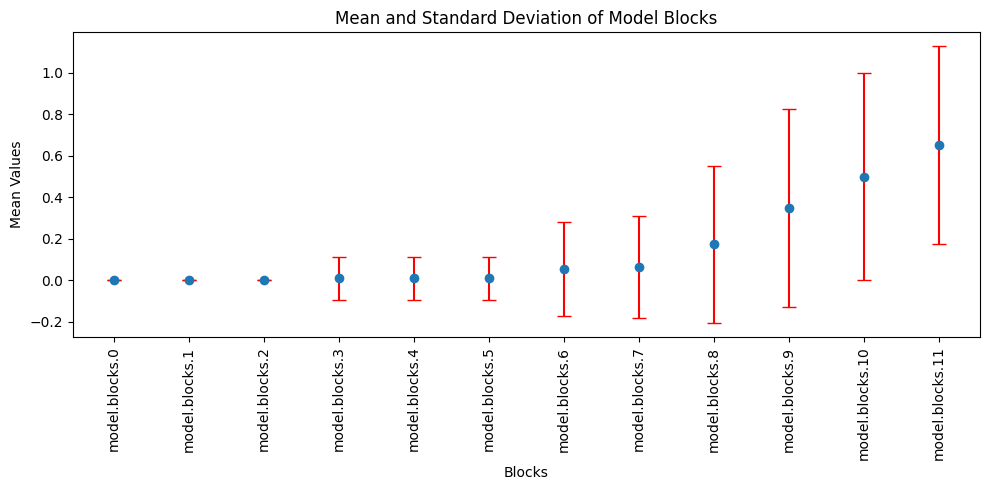

In [305]:
import matplotlib.pyplot as plt
# Filter out the keys where the mean or variance is NaN
keys = [k for k in means.keys() if not np.isnan(means[k]) and not np.isnan(variances[k])]
means_filtered = [means[k] for k in keys]
variances_filtered = [variances[k] for k in keys]


variances_filtered = [variances[k] for k in keys]

# Calculate the standard deviation from the variance
std_devs = np.sqrt(variances_filtered)

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(keys, means_filtered, yerr=std_devs, fmt='o', ecolor='red', capsize=5)
plt.xticks(rotation=90)  # Rotate the x labels to fit them nicely
plt.xlabel('Blocks')
plt.ylabel('Mean Values')
plt.title('Mean and Standard Deviation of Model Blocks')
plt.tight_layout()  
plt.show()